In [1]:
import pandas as pd
import numpy as np
import os
import string
import math
from time import localtime, strftime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn import decomposition
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
data_dir = "./Data/"

train = pd.read_csv("./Data/train.csv")
test_x = pd.read_csv("./Data/test.csv")
test_y = pd.read_csv("./Data/gender_submission.csv")

train_y = train["Survived"]
train_x = train.drop(["Survived"], axis=1)
train_len = train_x.shape[0]
test_len = test_x.shape[0]

data = pd.concat([train_x, test_x], axis=0)
print(data.shape)
data.info()
data.isna().sum().sort_values(ascending=False)

(1309, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


Cabin          1014
Age             263
Embarked          2
Fare              1
PassengerId       0
Pclass            0
Name              0
Sex               0
SibSp             0
Parch             0
Ticket            0
dtype: int64

In [5]:
object_feature = []
number_feature = []
for fea in data.columns:
    dtype = data[fea].dtype
    if dtype == "float64" or dtype == "int64":
        number_feature.append(fea)
    if dtype == "object":
        object_feature.append(fea)
print("Object Features:", object_feature)
print("Numeric Features:", number_feature)

Object Features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numeric Features: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


C:\Users\HSIN\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


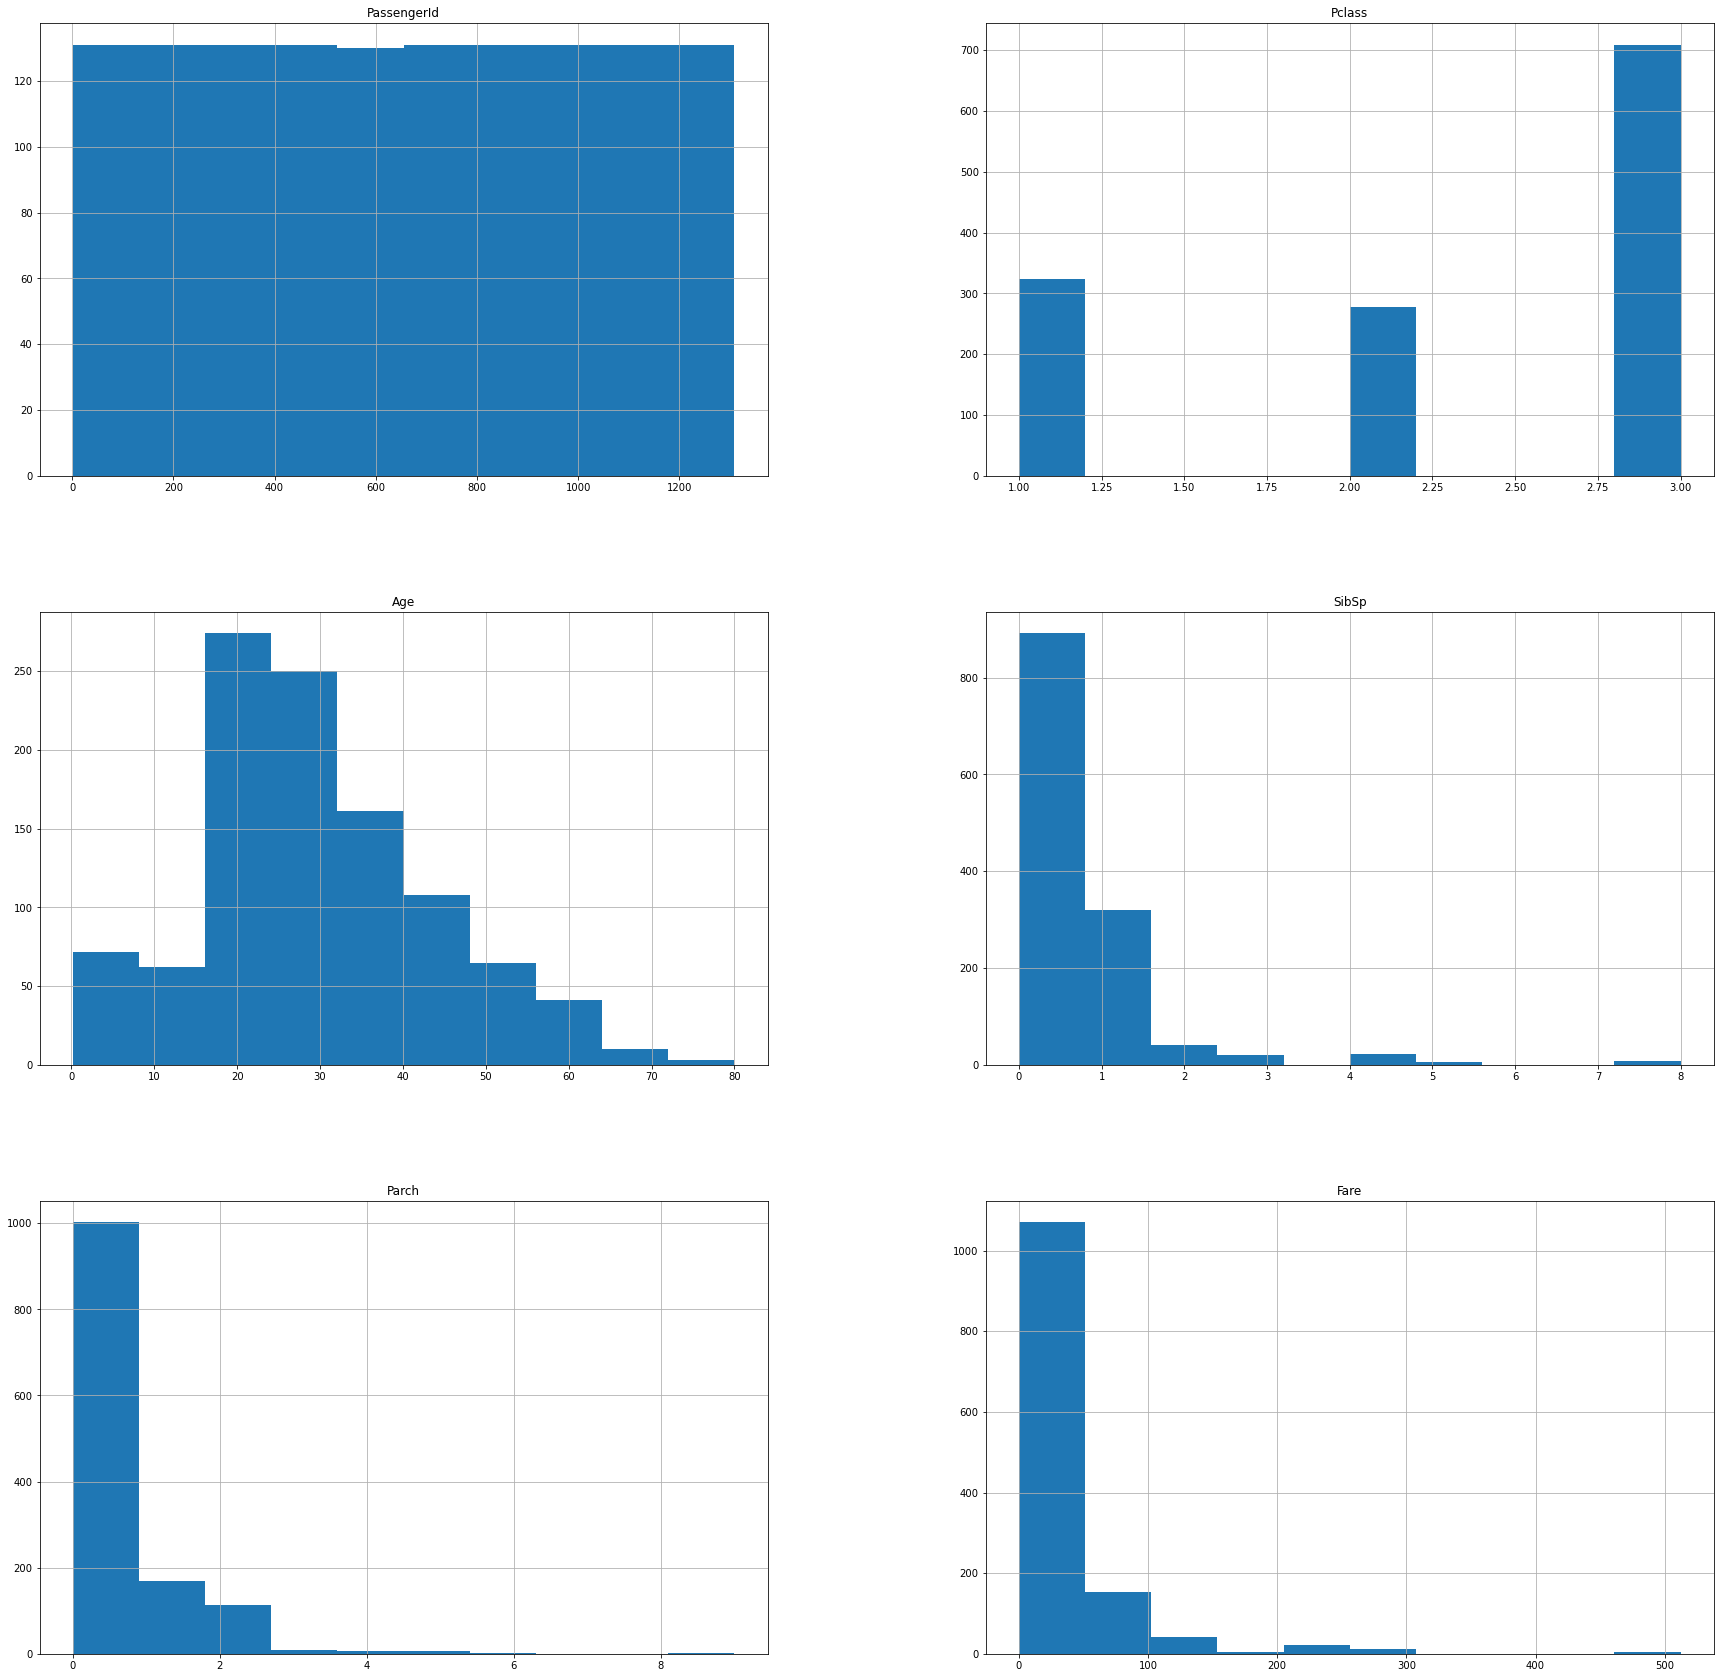

In [6]:
fig = plt.figure(figsize = (30,30))
ax = fig.gca()
data.hist(ax = ax)
plt.show()

In [7]:
def Missing_Replace(data, fea_array, replace="None"):
    for fea in fea_array:
        if replace == "Mean":
            data[fea] = data[fea].fillna(data[fea].mean())
        elif replace == "Mode":
            data[fea] = data[fea].fillna(str(data[fea].mode()[0]))
        elif replace == "Max":
            data[fea] = data[fea].fillna(data[fea].max())
        else:
            data[fea] = data[fea].fillna(replace)
    return data

data_pd = data.copy()
data_pd = Missing_Replace(data_pd, ["Age", "Fare"], replace="Mean")
data_pd = Missing_Replace(data_pd, ["Embarked"], replace="Mode")
data_pd = Missing_Replace(data_pd, ["Cabin"])
print(data_pd.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1309 non-null   float64
 9   Cabin        1309 non-null   object 
 10  Embarked     1309 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB
None


In [8]:
print(object_feature)
data_pd = pd.get_dummies(data_pd, columns=['Sex', "Embarked"])
#for fea in ['Cabin']:
    #data_fe[fea] = LabelEncoder.fit_transform(data_fe[fea])
data_pd = data_pd.drop(["Name", "Ticket", "Cabin"], axis=1)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [9]:
TRAIN_X = data_pd.iloc[:train_len,:]
TEST_X = data_pd.iloc[train_len:,:]
print(TRAIN_X.shape)
print(TEST_X.shape)

(891, 11)
(418, 11)


In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_X, train_y, test_size = 0.2)

In [11]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_valid)
print("Accuracy:%.2f" %metrics.accuracy_score(y_valid, xgb_pred))

Accuracy:0.82


In [13]:
def write_result(ID, Survived, filename=""):
    result = pd.DataFrame(columns=["PassengerId", "Survived"])
    result["PassengerId"] = ID
    result["Survived"] = Survived
    result.to_csv(os.path.join("./Result/", filename), sep=",", index=False)
write_result(TEST_X["PassengerId"], xgb.predict(TEST_X), "Result_xgb.csv")